In [1]:
# theme du notebook
from jupyterthemes import jtplot
jtplot.style(theme='onedork', ticks=True, grid=False ,figsize = (8,8))

In [2]:
import zipfile
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import re
import pickle
from pycaret.classification import *
from collections import Counter
from pandas_profiling import ProfileReport
#from imblearn.under_sampling import ClusterCentroids
from contextlib import contextmanager
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, recall_score

In [3]:
PATH = 'data/'
ZIP_FILE = PATH+'home-credit-default-risk.zip'
'''with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(PATH)
os.remove(ZIP_FILE)'''
LIST_FILES = [PATH+f for f in os.listdir(PATH)]

In [4]:
# Dataframe de référence des informations sur les colonnes
COL_INFOS = pd.read_csv(LIST_FILES[7])
COL_INFOS = COL_INFOS.drop(COL_INFOS.columns[0], axis = 1)

# Récupération des informations sur colonnes d'un dataframe
def _get_col_descriptions(col):
    return list(COL_INFOS[COL_INFOS['Row']==col]['Description'].values)
# Récupération des fichiers où se trouve la colonne
def _get_col_tables(col):
    return list(COL_INFOS[COL_INFOS['Row']==col]['Table'].values)

def get_col_infos(col, t=None):
    tables = _get_col_tables(col)
    descriptions = _get_col_descriptions(col)
    return [tab+" : "+desc for tab,desc in zip(tables,descriptions)]

def get_df_lines(df,col,val):
    filt = df[col] == val
    return df[filt]

# Exploration 

In [83]:
my_application_test = pd.read_csv(LIST_FILES[0])
my_application_train = pd.read_csv(LIST_FILES[1])
my_bureau = pd.read_csv(LIST_FILES[2])
my_bureau_balance = pd.read_csv(LIST_FILES[3])
my_credit_card_balance = pd.read_csv(LIST_FILES[4])
my_installments_payments = pd.read_csv(LIST_FILES[8])
my_pos_cash_balance = pd.read_csv(LIST_FILES[9])
my_previous_application = pd.read_csv(LIST_FILES[10])
my_sample_submission = pd.read_csv(LIST_FILES[11])

In [5]:
problematic_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                     'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                     'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
app_train = my_application_train.drop(problematic_cols, axis = 1)
app_train.profile_report(correlations={'pearson': {'calculate': True},
                                       'spearman': {'calculate': False},
                                       'kendall': {'calculate': False},
                                       'phi_k': {'calculate': False},
                                       'cramers': {'calculate': False}},
                         interactions={'continuous':False})

NameError: name 'my_application_train' is not defined

# Feature Engineering 

## Ref FE

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    #df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['GOODS_CREDIT_PERC'] = df['AMT_CREDIT']/df['AMT_GOODS_PRICE']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean','sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean','sum']
    for cat in bb_cat: cat_aggregations[cat+'_MEAN'] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    active_agg.columns = pd.Index(['B_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    active_agg['B_ACTIVE_CREDIT_TYPE_Other credits_SUM'] = active_agg[['B_ACTIVE_CREDIT_TYPE_Another type of loan_SUM',
           'B_ACTIVE_CREDIT_TYPE_Car loan_SUM',
           'B_ACTIVE_CREDIT_TYPE_Cash loan (non-earmarked)_SUM',
           'B_ACTIVE_CREDIT_TYPE_Interbank credit_SUM',
           'B_ACTIVE_CREDIT_TYPE_Loan for business development_SUM',
           'B_ACTIVE_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM',
           'B_ACTIVE_CREDIT_TYPE_Loan for the purchase of equipment_SUM',
           'B_ACTIVE_CREDIT_TYPE_Loan for working capital replenishment_SUM',
           'B_ACTIVE_CREDIT_TYPE_Microloan_SUM',
           'B_ACTIVE_CREDIT_TYPE_Mobile operator loan_SUM',
           'B_ACTIVE_CREDIT_TYPE_Mortgage_SUM',
           'B_ACTIVE_CREDIT_TYPE_Real estate loan_SUM',
           'B_ACTIVE_CREDIT_TYPE_Unknown type of loan_SUM']].sum()
    
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [9]:
df = application_train_test()
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance()
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    #ajout du pourcentage des crédits bureau par rapport aux revenus totaux
    df['B_ACTIVE_AMT_ANNUITY_SUM_INCOME_PERCENT'] = df[
                'B_ACTIVE_AMT_ANNUITY_SUM']/df['AMT_INCOME_TOTAL']
    #del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications()
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    #del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash()
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    #del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments()
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    #del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance()
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    #del cc
    gc.collect()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 210)
Process bureau and bureau_balance - done in 19s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 15s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 26)
Process installments payments - done in 23s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 12s


## Custom FE

In [10]:
import re
cols=['SK_ID_CURR','TARGET','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN',
      'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
      'REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','OWN_CAR_AGE',
      'CNT_FAM_MEMBERS','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
      'NAME_CONTRACT_TYPE_Cash loans','NAME_CONTRACT_TYPE_Revolving loans',
      'NAME_INCOME_TYPE_Maternity leave','NAME_INCOME_TYPE_Pensioner',
      'NAME_INCOME_TYPE_State servant','NAME_INCOME_TYPE_Student',
      'NAME_INCOME_TYPE_Unemployed','NAME_INCOME_TYPE_Working',
      'NAME_EDUCATION_TYPE_Academic degree','NAME_EDUCATION_TYPE_Higher education',
      'NAME_EDUCATION_TYPE_Incomplete higher','NAME_EDUCATION_TYPE_Lower secondary',
      'NAME_EDUCATION_TYPE_Secondary / secondary special','NAME_FAMILY_STATUS_Civil marriage',
      'NAME_FAMILY_STATUS_Married','NAME_FAMILY_STATUS_Separated',
      'NAME_FAMILY_STATUS_Single / not married','NAME_FAMILY_STATUS_Widow',
      'NAME_HOUSING_TYPE_Co-op apartment','NAME_HOUSING_TYPE_House / apartment',
      'NAME_HOUSING_TYPE_Municipal apartment','NAME_HOUSING_TYPE_Office apartment',
      'NAME_HOUSING_TYPE_Rented apartment','NAME_HOUSING_TYPE_With parents',
      'OCCUPATION_TYPE_Cleaning staff','OCCUPATION_TYPE_Cooking staff',
      'OCCUPATION_TYPE_Core staff','OCCUPATION_TYPE_Drivers','OCCUPATION_TYPE_HR staff',
      'OCCUPATION_TYPE_High skill tech staff','OCCUPATION_TYPE_IT staff',
      'OCCUPATION_TYPE_Laborers','OCCUPATION_TYPE_Low-skill Laborers',
      'OCCUPATION_TYPE_Managers','OCCUPATION_TYPE_Medicine staff',
      'OCCUPATION_TYPE_Private service staff','OCCUPATION_TYPE_Realty agents',
      'OCCUPATION_TYPE_Sales staff','OCCUPATION_TYPE_Secretaries',
      'OCCUPATION_TYPE_Security staff','OCCUPATION_TYPE_Waiters/barmen staff',
      'ORGANIZATION_TYPE_Advertising','ORGANIZATION_TYPE_Agriculture','ORGANIZATION_TYPE_Bank',
      'ORGANIZATION_TYPE_Business Entity Type 1','ORGANIZATION_TYPE_Business Entity Type 2',
      'ORGANIZATION_TYPE_Business Entity Type 3','ORGANIZATION_TYPE_Cleaning',
      'ORGANIZATION_TYPE_Construction','ORGANIZATION_TYPE_Culture',
      'ORGANIZATION_TYPE_Electricity','ORGANIZATION_TYPE_Emergency',
      'ORGANIZATION_TYPE_Government','ORGANIZATION_TYPE_Hotel','ORGANIZATION_TYPE_Housing',
      'ORGANIZATION_TYPE_Industry: type 1','ORGANIZATION_TYPE_Industry: type 2',
      'ORGANIZATION_TYPE_Industry: type 3','ORGANIZATION_TYPE_Industry: type 4',
      'ORGANIZATION_TYPE_Industry: type 5','ORGANIZATION_TYPE_Industry: type 6',
      'ORGANIZATION_TYPE_Industry: type 7','ORGANIZATION_TYPE_Industry: type 8',
      'ORGANIZATION_TYPE_Industry: type 9','ORGANIZATION_TYPE_Industry: type 10',
      'ORGANIZATION_TYPE_Industry: type 11','ORGANIZATION_TYPE_Industry: type 12',
      'ORGANIZATION_TYPE_Industry: type 13','ORGANIZATION_TYPE_Insurance',
      'ORGANIZATION_TYPE_Kindergarten','ORGANIZATION_TYPE_Legal Services',
      'ORGANIZATION_TYPE_Medicine','ORGANIZATION_TYPE_Military','ORGANIZATION_TYPE_Mobile',
      'ORGANIZATION_TYPE_Other','ORGANIZATION_TYPE_Police','ORGANIZATION_TYPE_Postal',
      'ORGANIZATION_TYPE_Realtor','ORGANIZATION_TYPE_Religion','ORGANIZATION_TYPE_Restaurant',
      'ORGANIZATION_TYPE_School','ORGANIZATION_TYPE_Security',
      'ORGANIZATION_TYPE_Security Ministries','ORGANIZATION_TYPE_Self-employed',
      'ORGANIZATION_TYPE_Services','ORGANIZATION_TYPE_Telecom',
      'ORGANIZATION_TYPE_Trade: type 1','ORGANIZATION_TYPE_Trade: type 2',
      'ORGANIZATION_TYPE_Trade: type 3','ORGANIZATION_TYPE_Trade: type 4',
      'ORGANIZATION_TYPE_Trade: type 5','ORGANIZATION_TYPE_Trade: type 6',
      'ORGANIZATION_TYPE_Trade: type 7','ORGANIZATION_TYPE_Transport: type 1',
      'ORGANIZATION_TYPE_Transport: type 2','ORGANIZATION_TYPE_Transport: type 3',
      'ORGANIZATION_TYPE_Transport: type 4','ORGANIZATION_TYPE_University',
      'ORGANIZATION_TYPE_XNA','DAYS_EMPLOYED_PERC','INCOME_CREDIT_PERC','ANNUITY_INCOME_PERC',
      'PAYMENT_RATE','GOODS_CREDIT_PERC',
      'BURO_CREDIT_DAY_OVERDUE_MAX','BURO_CREDIT_DAY_OVERDUE_MEAN',
      'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN','BURO_AMT_CREDIT_MAX_OVERDUE_MAX',
      'B_ACTIVE_DAYS_CREDIT_MIN','B_ACTIVE_DAYS_CREDIT_MAX','B_ACTIVE_DAYS_CREDIT_MEAN',
      'B_ACTIVE_DAYS_CREDIT_VAR','B_ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
      'B_ACTIVE_DAYS_CREDIT_ENDDATE_MAX','B_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
      'B_ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
      'B_ACTIVE_AMT_CREDIT_SUM_MEAN','B_ACTIVE_AMT_CREDIT_SUM_SUM',
      'B_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX','B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
      'B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM','B_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
      'B_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN','B_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
      'B_ACTIVE_AMT_ANNUITY_MAX','B_ACTIVE_AMT_ANNUITY_MEAN','B_ACTIVE_AMT_ANNUITY_SUM',
      'B_ACTIVE_CREDIT_TYPE_Another type of loan_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Another type of loan_SUM',
      'B_ACTIVE_CREDIT_TYPE_Car loan_MEAN','B_ACTIVE_CREDIT_TYPE_Car loan_SUM',
      'B_ACTIVE_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Cash loan (non-earmarked)_SUM',
      'B_ACTIVE_CREDIT_TYPE_Consumer credit_MEAN','B_ACTIVE_CREDIT_TYPE_Consumer credit_SUM',
      'B_ACTIVE_CREDIT_TYPE_Credit card_MEAN','B_ACTIVE_CREDIT_TYPE_Credit card_SUM',
      'B_ACTIVE_CREDIT_TYPE_Interbank credit_MEAN','B_ACTIVE_CREDIT_TYPE_Interbank credit_SUM',
      'B_ACTIVE_CREDIT_TYPE_Loan for business development_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Loan for business development_SUM',
      'B_ACTIVE_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM',
      'B_ACTIVE_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Loan for the purchase of equipment_SUM',
      'B_ACTIVE_CREDIT_TYPE_Loan for working capital replenishment_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Loan for working capital replenishment_SUM',
      'B_ACTIVE_CREDIT_TYPE_Microloan_MEAN','B_ACTIVE_CREDIT_TYPE_Microloan_SUM',
      'B_ACTIVE_CREDIT_TYPE_Mobile operator loan_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Mobile operator loan_SUM','B_ACTIVE_CREDIT_TYPE_Mortgage_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Mortgage_SUM','B_ACTIVE_CREDIT_TYPE_Real estate loan_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Real estate loan_SUM',
      'B_ACTIVE_CREDIT_TYPE_Unknown type of loan_MEAN',
      'B_ACTIVE_CREDIT_TYPE_Unknown type of loan_SUM','B_ACTIVE_CREDIT_TYPE_nan_MEAN',
      'B_ACTIVE_CREDIT_TYPE_nan_SUM','B_ACTIVE_AMT_ANNUITY_SUM_INCOME_PERCENT',
       'APPROVED_AMT_ANNUITY_MIN','APPROVED_AMT_ANNUITY_MAX','APPROVED_AMT_ANNUITY_MEAN',
      'APPROVED_AMT_APPLICATION_MIN','APPROVED_AMT_APPLICATION_MAX',
      'APPROVED_AMT_APPLICATION_MEAN','APPROVED_AMT_CREDIT_MIN','APPROVED_AMT_CREDIT_MAX',
      'APPROVED_AMT_CREDIT_MEAN','APPROVED_APP_CREDIT_PERC_MIN','APPROVED_APP_CREDIT_PERC_MAX',
      'APPROVED_APP_CREDIT_PERC_MEAN']
#cols =[re.sub('[^A-Za-z0-9_]+', '', c) for c in cols]
df2= df[cols]

# Modèle 

## Ref Model 

In [11]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            n_jobs=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            #is_unbalance=True,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        if not debug:
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        filename = str(n_fold + 1)+'_model.sav'
        print(filename)
        pickle.dump(clf, open(filename, 'wb'))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [13]:
submission_file_name = "submission_kernel_ref.csv"
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
my_df_train_ref, my_df_tst_ref = train_test_split(df, test_size=0.25, random_state=2009)
with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(my_df_train_ref, num_folds= 10, stratified= False, debug= False)

Starting LightGBM. Train shape: (230830, 894), test shape: (36361, 894)
Training until validation scores don't improve for 200 rounds


KeyboardInterrupt: 

#### Scores

In [22]:
train_df = df[df['TARGET'].notnull()]
train_df_ref = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_ref = df[df['TARGET'].isnull()]
df_train_ref, df_tst_ref = train_test_split(train_df_ref, test_size=0.25, random_state=2009)
feats = [f for f in train_df.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = df_train_ref[feats]
y = df_train_ref['TARGET']
ref_model =LGBMClassifier(
            n_jobs=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            #is_unbalance=True, 
            )
ref_model.fit(X, y, eval_metric= 'auc', verbose= 2)

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, n_jobs=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

In [23]:
X_test = df_tst_ref[feats]
y_test = df_tst_ref['TARGET']
y_pred = ref_model.predict(X_test)
y_proba = ref_model.predict_proba(X_test)[:,1]

In [24]:
roc_auc_score(y_test, y_proba)

0.7770037600266844

In [40]:
def get_best_threshold(y_test,y_proba):
    # calculate roc curves
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = threshold[ix]
    print('Best Threshold=%f' % (best_thresh))
    return best_thresh,ix

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def get_best_fscore_threshold(y_test,y_proba):
    # calculate roc curves
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(y_proba, t)) for t in threshold]
    # get best threshold
    ix_f1 = np.argmax(scores)
    best_thresh_f1 = threshold[ix_f1]
    print('F-score optimized Threshold=%.3f, F-Score=%.5f' % (best_thresh_f1, scores[ix_f1]))
    return best_thresh_f1,ix_f1

def display_roc_curve(y_test,y_proba,ix=None,ix_f1=None):
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'model')
    plt.plot([0, 1], ls="--", label = 'random')
    if ix is not None:
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
    if ix_f1 is not None:
        plt.scatter(fpr[ix_f1], tpr[ix_f1], marker='o', color='yellow', label='F1')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()
    
def display_confusion_matrix(y_ref,y_predict):
    cm = confusion_matrix(y_ref,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation="vertical")

def display_classification_report(y_ref,y_predict):
    return pd.DataFrame(classification_report(y_ref,y_predict, 
                                              output_dict=True,))

Best Threshold=0.061080
F-score optimized Threshold=0.130, F-Score=0.33570


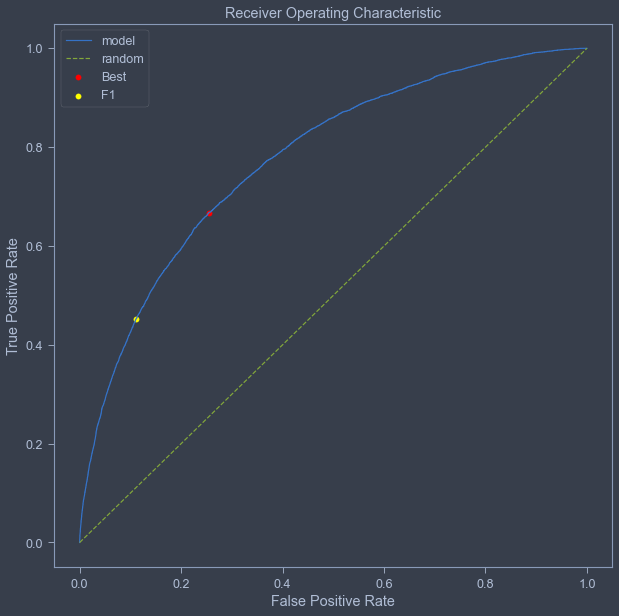

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.961739,0.189493,0.738989,0.575616,0.898505
recall,0.745364,0.667514,0.738989,0.706439,0.738989
f1-score,0.839838,0.295188,0.738989,0.567513,0.795241
support,70583.000000,6295.000000,0.738989,76878.000000,76878.000000


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.947862,0.267237,0.853742,0.607550,0.892130
recall,0.889633,0.451311,0.853742,0.670472,0.853742
f1-score,0.917825,0.335697,0.853742,0.626761,0.870159
support,70583.000000,6295.000000,0.853742,76878.000000,76878.000000


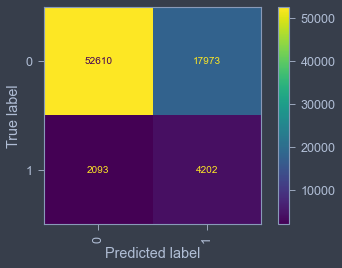

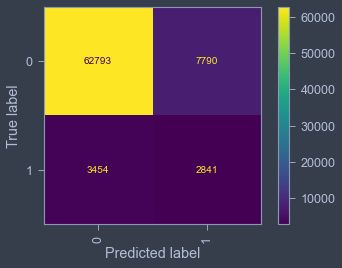

In [48]:
thres,ix = get_best_threshold(y_test,y_proba)
f_thres, ix_f1 = get_best_fscore_threshold(y_test,y_proba)
display_roc_curve(y_test,y_proba,ix,ix_f1)
display_confusion_matrix(y_test,to_labels(y_proba,thres))
display(display_classification_report(y_test,to_labels(y_proba,thres)))
display_confusion_matrix(y_test,to_labels(y_proba,f_thres))
display(display_classification_report(y_test,to_labels(y_proba,f_thres)))

## Custom model

In [50]:
train_df = df2[df2['TARGET'].notnull()]
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = df[df['TARGET'].isnull()]
my_df_train, my_df_tst = train_test_split(train_df, test_size=0.25, random_state=2009)

In [51]:
feats = [f for f in train_df.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = my_df_train[feats]
y = my_df_train['TARGET']
my_model = LGBMClassifier(
            n_jobs=4,
            n_estimators=1168, 
            learning_rate=0.017655722466828314,
            num_leaves=59, 
            colsample_bytree=0.569167369690406,
            subsample=0.535570933277176,
            max_depth=10,
            reg_alpha=0.9548494947192124,
            reg_lambda=0.6503706549210739,
            min_split_gain=0.24088547099103652,
            min_child_weight=49,
            silent=-1,
            verbose=-1, )
my_model.fit(X, y, eval_metric= 'auc', verbose= 2)

LGBMClassifier(colsample_bytree=0.569167369690406,
               learning_rate=0.017655722466828314, max_depth=10,
               min_child_weight=49, min_split_gain=0.24088547099103652,
               n_estimators=1168, n_jobs=4, num_leaves=59,
               reg_alpha=0.9548494947192124, reg_lambda=0.6503706549210739,
               silent=-1, subsample=0.535570933277176, verbose=-1)

In [11]:
from skopt import BayesSearchCV
# SETTINGS 
ITERATIONS = 10# 1000
TRAINING_SIZE = 100000 # 20000000
TEST_SIZE = 25000
# Split into X and y
feats = [f for f in my_df_train.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = my_df_train[feats]
y = my_df_train['TARGET']
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = LGBMClassifier(eval_metric ='roc_auc'),
    search_spaces = {
        'n_estimators': (100, 2000),
        'learning_rate': (.01, 1),
        'num_leaves':(20,60),
        'colsample_bytree':(.1,1),
        'subsample':(.01,1),
        'max_depth':(1,10),
        'reg_alpha':(0.,1),
        'reg_lambda':(0.,1),
        'min_split_gain':(0.,1),
        'min_child_weight':(10,50),
    },
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=2009
    ),
    #n_points = 4,
    n_jobs = 4,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 2009
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")


result = bayes_cv_tuner.fit(X.values, y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.7113
Best params: OrderedDict([('colsample_bytree', 0.22536057344321467), ('learning_rate', 0.9535752881111842), ('max_depth', 6), ('min_child_weight', 31), ('min_split_gain', 0.9335474471821296), ('n_estimators', 665), ('num_leaves', 60), ('reg_alpha', 0.7514851289689534), ('reg_lambda', 0.12557256458822588), ('subsample', 0.76697725728093)])

Model #2
Best ROC-AUC: 0.7663
Best params: OrderedDict([('colsample_bytree', 0.4368458227519082), ('learning_rate', 0.686191431179651), ('max_depth', 1), ('min_child_weight', 12), ('min_split_gain', 0.03939695670623556), ('n_estimators', 351), ('num_leaves', 49), ('reg_alpha', 0.0639926690175643), ('reg_lambda', 0.5064326907532327), ('subsample', 0.06334583180046699)])

Model #3
Best ROC-AUC: 0.7663
Best params: OrderedDict([('colsample_bytree', 0.4368458227519082), ('learning_rate', 0.686191431179651), ('max_depth', 1), ('min_child_weight', 12), ('min_split_gain', 0.03939695670623556), ('n_estimators', 351), ('num_leave

# Resultats 

## AUC 

In [265]:
feats = [f for f in my_df_train.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = my_df_train[feats]
y = my_df_train['TARGET']
my_model3 = LGBMClassifier(
            n_jobs=4,
            n_estimators=1168, 
            learning_rate=0.017655722466828314,
            num_leaves=59, 
            colsample_bytree=0.569167369690406,
            subsample=0.535570933277176,
            max_depth=10,
            reg_alpha=0.9548494947192124,
            reg_lambda=0.6503706549210739,
            min_split_gain=0.24088547099103652,
            min_child_weight=49,
            silent=-1,
            verbose=-1,
            )
my_model3.fit(X1, y1, eval_metric= 'auc', verbose= 2)

LGBMClassifier(colsample_bytree=0.569167369690406,
               learning_rate=0.017655722466828314, max_depth=10,
               min_child_weight=49, min_split_gain=0.24088547099103652,
               n_estimators=1168, n_jobs=4, num_leaves=59,
               reg_alpha=0.9548494947192124, reg_lambda=0.6503706549210739,
               silent=-1, subsample=0.535570933277176, verbose=-1)

In [53]:
X_test = my_df_tst[feats]
y_test = my_df_tst['TARGET']
y_pred = my_model.predict(X_test)
y_proba = my_model.predict_proba(X_test)[:,1]

In [55]:
roc_auc_score(y_test, y_proba)

0.7778415548875209

Best Threshold=0.072378
F-score optimized Threshold=0.165, F-Score=0.33206


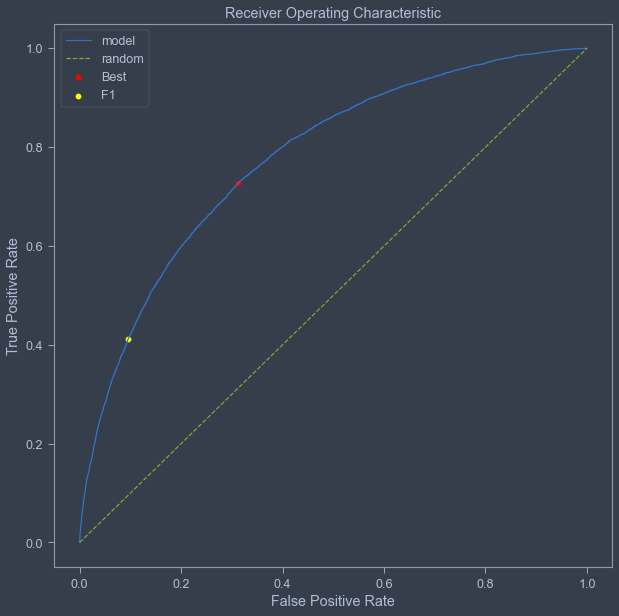

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.965837,0.171982,0.690965,0.568910,0.900834
recall,0.687729,0.727244,0.690965,0.707487,0.690965
f1-score,0.803396,0.278179,0.690965,0.540788,0.760390
support,70583.000000,6295.000000,0.690965,76878.000000,76878.000000


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.945250,0.277772,0.864044,0.611511,0.890595
recall,0.904297,0.412708,0.864044,0.658503,0.864044
f1-score,0.924320,0.332055,0.864044,0.628188,0.875824
support,70583.000000,6295.000000,0.864044,76878.000000,76878.000000


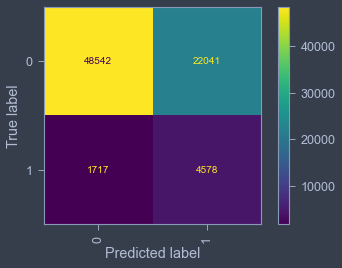

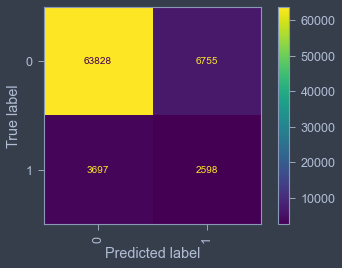

In [54]:
thres,ix = get_best_threshold(y_test,y_proba)
f_thres, ix_f1 = get_best_fscore_threshold(y_test,y_proba)
display_roc_curve(y_test,y_proba,ix,ix_f1)
display_confusion_matrix(y_test,to_labels(y_proba,thres))
display(display_classification_report(y_test,to_labels(y_proba,thres)))
display_confusion_matrix(y_test,to_labels(y_proba,f_thres))
display(display_classification_report(y_test,to_labels(y_proba,f_thres)))

## Seuil de prediction

In [269]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [270]:
# calculate roc curves
fpr, tpr, threshold = roc_curve(y_test, y_proba)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = threshold[ix]
print('Best Threshold=%f' % (best_thresh))
# evaluate each threshold
scores = [f1_score(y_test, to_labels(y_proba, t)) for t in threshold]
# get best threshold
ix_f1 = np.argmax(scores)
best_thresh_f1 = threshold[ix_f1]
print('F-score optimized Threshold=%.3f, F-Score=%.5f' % (best_thresh_f1, scores[ix_f1]))

Best Threshold=0.085644
F-score optimized Threshold=0.174, F-Score=0.30311


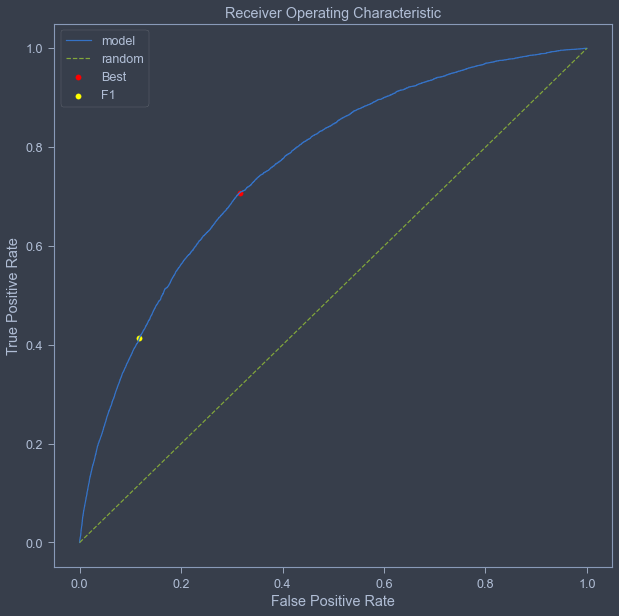

In [271]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'model')
plt.plot([0, 1], ls="--", label = 'random')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.scatter(fpr[ix_f1], tpr[ix_f1], marker='o', color='yellow', label='F1')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [272]:
def display_confusion_matrix(y_ref,y_predict):
    cm = confusion_matrix(y_ref,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation="vertical")
def display_classification_report(y_ref,y_predict):
    return pd.DataFrame(classification_report(y_ref,y_predict, 
                                              output_dict=True,))

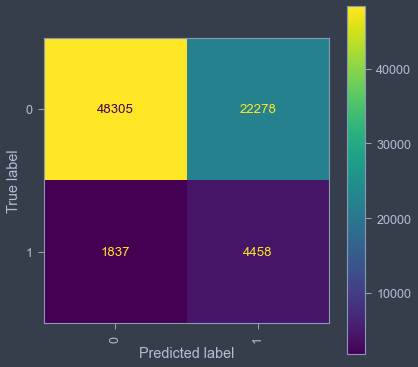

In [273]:
display_confusion_matrix(y_test,to_labels(y_proba,best_thresh))

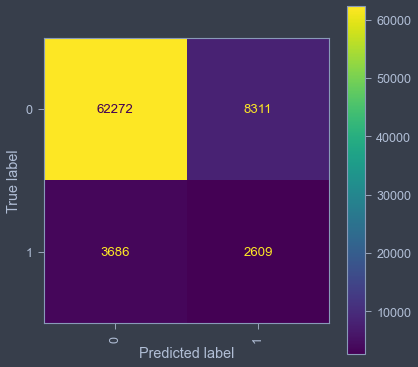

In [274]:
display_confusion_matrix(y_test,to_labels(y_proba,best_thresh_f1))

In [275]:
display_classification_report(y_test,to_labels(y_proba,best_thresh))

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.963364,0.166741,0.686321,0.565053,0.898134
recall,0.684372,0.708181,0.686321,0.696276,0.686321
f1-score,0.800248,0.269928,0.686321,0.535088,0.756824
support,70583.000000,6295.000000,0.686321,76878.000000,76878.000000


In [276]:
display_classification_report(y_test,to_labels(y_proba,best_thresh_f1))

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.944116,0.238919,0.843948,0.591518,0.886372
recall,0.882252,0.414456,0.843948,0.648354,0.843948
f1-score,0.912136,0.303108,0.843948,0.607622,0.862267
support,70583.000000,6295.000000,0.843948,76878.000000,76878.000000


In [165]:
roc = pd.DataFrame()
roc['ABS'] = np.linspace(0,1,(len(fpr)))
roc['FPR'] = fpr
roc['TPR'] = tpr
roc['RND'] = roc['ABS']
roc = roc[::100]
roc.to_csv('roc.csv')

In [185]:
my_full_df = my_application_train.append(my_application_test).reset_index().drop(['index'],axis=1)

In [188]:
cat_cols = ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
            'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
df_tmp = df2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) 
my_full_df = df_tmp.join(my_full_df[cat_cols], how='left')

In [232]:
my_full_df[my_full_df['TARGET'].notnull()].to_csv('data/df_train.csv')
my_full_df[my_full_df['TARGET'].isnull()].to_csv('data/df_test.csv')
my_full_df.to_csv('data/df_full.csv')

In [179]:
[c for c in my_full_df.columns]

['SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'NAME_CONTRACT_TYPE_Cashloans',
 'NAME_CONTRACT_TYPE_Revolvingloans',
 'NAME_INCOME_TYPE_Maternityleave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Stateservant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academicdegree',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Incompletehigher',
 'NAME_EDUCATION_TYPE_Lowersecondary',
 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
 'NAME_FAMILY_STATUS_Civilmarriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Singlenotmarried',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Coopapartment',
 'NA

In [184]:
my_full_df[my_full_df['TARGET'].isnull()].head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORGANIZATION_TYPE_Transporttype2,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Transporttype4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,GOODS_CREDIT_PERC,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MAX,B_ACTIVE_DAYS_CREDIT_MIN,B_ACTIVE_DAYS_CREDIT_MAX,B_ACTIVE_DAYS_CREDIT_MEAN,B_ACTIVE_DAYS_CREDIT_VAR,B_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,B_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,B_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,B_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_MEAN,B_ACTIVE_AMT_CREDIT_SUM_SUM,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,B_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,B_ACTIVE_AMT_ANNUITY_MAX,B_ACTIVE_AMT_ANNUITY_MEAN,B_ACTIVE_AM

In [189]:
my_full_df[my_full_df['TARGET'].isnull()][cat_cols].head()

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,ORGANIZATION_TYPE
307511,Cash loans,Working,Higher education,Married,NaN,Kindergarten
307512,Cash loans,Working,Secondary / secondary special,Married,Low-skill Laborers,Self-employed
307513,Cash loans,Working,Higher education,Married,Drivers,Transport: type 3
307514,Cash loans,Working,Secondary / secondary special,Married,Sales staff,Business Entity Type 3
307515,Cash loans,Working,Secondary / secondary special,Married,NaN,Business Entity Type 3


In [192]:
import pickle
filename = 'my_model.sav'
pickle.dump(my_model, open(filename, 'wb'))

In [212]:
df_test = my_full_df[my_full_df['TARGET'].isnull()]
df_test = df_test

In [213]:
my_model = pickle.load(open(filename, 'rb'))

In [214]:
my_full_df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORGANIZATION_TYPE_Transporttype2,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Transporttype4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,GOODS_CREDIT_PERC,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MAX,B_ACTIVE_DAYS_CREDIT_MIN,B_ACTIVE_DAYS_CREDIT_MAX,B_ACTIVE_DAYS_CREDIT_MEAN,B_ACTIVE_DAYS_CREDIT_VAR,B_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,B_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,B_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,B_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_MEAN,B_ACTIVE_AMT_CREDIT_SUM_SUM,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,B_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,B_ACTIVE_AMT_ANNUITY_MAX,B_ACTIVE_AMT_ANNUITY_MEAN,B_ACTIVE_AM

In [215]:
loaded_model.predict_proba([df_test[feats].iloc[0]])[:,1][0]

0.04264670794134877

In [206]:
df_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORGANIZATION_TYPE_Transporttype2,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Transporttype4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,GOODS_CREDIT_PERC,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MAX,B_ACTIVE_DAYS_CREDIT_MIN,B_ACTIVE_DAYS_CREDIT_MAX,B_ACTIVE_DAYS_CREDIT_MEAN,B_ACTIVE_DAYS_CREDIT_VAR,B_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,B_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,B_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,B_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_MEAN,B_ACTIVE_AMT_CREDIT_SUM_SUM,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,B_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,B_ACTIVE_AMT_ANNUITY_MAX,B_ACTIVE_AMT_ANNUITY_MEAN,B_ACTIVE_AMT_ANNUITY_SUM,B_AC

In [224]:
loaded_model.

defaultdict(collections.OrderedDict, {})

In [226]:
my_full_df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORGANIZATION_TYPE_Transporttype2,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Transporttype4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,GOODS_CREDIT_PERC,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MAX,B_ACTIVE_DAYS_CREDIT_MIN,B_ACTIVE_DAYS_CREDIT_MAX,B_ACTIVE_DAYS_CREDIT_MEAN,B_ACTIVE_DAYS_CREDIT_VAR,B_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,B_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,B_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,B_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_MEAN,B_ACTIVE_AMT_CREDIT_SUM_SUM,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,B_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,B_ACTIVE_AMT_ANNUITY_MAX,B_ACTIVE_AMT_ANNUITY_MEAN,B_ACTIVE_AM

<AxesSubplot:xlabel='TARGET'>

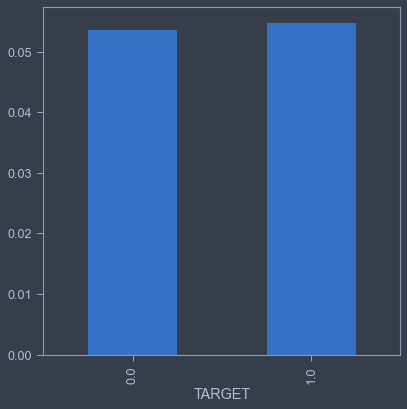

In [227]:
group='TARGET'
col='PAYMENT_RATE'
df_g = my_full_df.groupby([group])[col].mean()
df_g.plot.bar()

In [228]:
my_model.feature_name_

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'NAME_CONTRACT_TYPE_Cashloans',
 'NAME_CONTRACT_TYPE_Revolvingloans',
 'NAME_INCOME_TYPE_Maternityleave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Stateservant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academicdegree',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Incompletehigher',
 'NAME_EDUCATION_TYPE_Lowersecondary',
 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
 'NAME_FAMILY_STATUS_Civilmarriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Singlenotmarried',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Coopapartment',
 'NAME_HOUSING_TYPE_Houseapart

In [231]:
[i for i in my_full_df[my_full_df['TARGET'].isnull()]['SK_ID_CURR']]

[100001,
 100005,
 100013,
 100028,
 100038,
 100042,
 100057,
 100065,
 100066,
 100067,
 100074,
 100090,
 100091,
 100092,
 100106,
 100107,
 100109,
 100117,
 100128,
 100141,
 100150,
 100168,
 100169,
 100170,
 100171,
 100172,
 100184,
 100187,
 100212,
 100222,
 100223,
 100232,
 100241,
 100245,
 100253,
 100256,
 100271,
 100278,
 100280,
 100306,
 100311,
 100312,
 100330,
 100331,
 100352,
 100358,
 100367,
 100382,
 100384,
 100385,
 100386,
 100399,
 100404,
 100416,
 100422,
 100426,
 100438,
 100444,
 100445,
 100446,
 100447,
 100450,
 100466,
 100483,
 100484,
 100494,
 100510,
 100512,
 100517,
 100548,
 100551,
 100552,
 100553,
 100561,
 100568,
 100569,
 100591,
 100592,
 100602,
 100607,
 100613,
 100617,
 100618,
 100622,
 100625,
 100677,
 100699,
 100702,
 100711,
 100729,
 100740,
 100744,
 100745,
 100747,
 100751,
 100752,
 100753,
 100754,
 100760,
 100762,
 100763,
 100765,
 100770,
 100772,
 100777,
 100791,
 100792,
 100797,
 100823,
 100826,
 100830,
 

In [233]:
MODEL_PATH = 'my_model.sav'
DATA_PATH = 'data/df_full.csv'
df = pd.read_csv(DATA_PATH,).sort_values(['SK_ID_CURR']).iloc[: , 1:]
model = pickle.load(open(MODEL_PATH, 'rb'))

In [238]:
SK_ID = 100005
client_df = df[df['SK_ID_CURR']==SK_ID]

In [239]:
client_df.shape

(1, 196)

In [240]:
client_df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORGANIZATION_TYPE_Transporttype2,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Transporttype4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,GOODS_CREDIT_PERC,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MAX,B_ACTIVE_DAYS_CREDIT_MIN,B_ACTIVE_DAYS_CREDIT_MAX,B_ACTIVE_DAYS_CREDIT_MEAN,B_ACTIVE_DAYS_CREDIT_VAR,B_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,B_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,B_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,B_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_MEAN,B_ACTIVE_AMT_CREDIT_SUM_SUM,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,B_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,B_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,B_ACTIVE_AMT_ANNUITY_MAX,B_ACTIVE_AMT_ANNUITY_MEAN,B_ACTIVE_AM

In [242]:
COLS_CAT = ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
FEATS = [f for f in df.columns if f not in (
        COLS_CAT+['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index'])]
model.predict_proba(client_df[FEATS])[:,1][0]

0.08574347072607645

# Equilibrage des classes

In [56]:
counter = Counter(y)
print(counter)

Counter({0.0: 212103, 1.0: 18530})


In [59]:
from sklearn.manifold import TSNE
def make_tsne(df_ref,colors,nc=None):
    tsne = TSNE(n_components=2,perplexity=50)
    disp = len(df_ref)
    if nc is not None:
        df_centroids = pd.DataFrame(nc.centroids_,index = nc.classes_,columns=df_ref.columns)
        if -1 in nc.classes_ : df_centroids = df_centroids.drop([-1])
        df_ref = pd.concat([df_ref,df_centroids])
        #color_centroid = get_color(df_centroids.index)
        #colors = colors + color_centroid
    tesss= tsne.fit_transform(df_ref)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle('Distribution des individus',size=16)
    ax = fig.add_subplot()
    ax.scatter(tesss[:disp,0],tesss[:disp,1],c=colors,s=10)
    if nc is not None:
        ax.scatter(tesss[-len(df_centroids):,0],tesss[-len(df_centroids):,1],
                   c='red',s=10,marker='*')
    plt.savefig("t_sne.png",transparent=True)
    plt.show()

def get_color(labels):
    dictcol = {-1:'darkgray',
               0:'indigo',
               1:'darkred',
               2:'orange',
               3:'darkblue',
               4:'darkgreen',
               5:'darkcyan',
               6:'saddlebrown',
               7:'limegreen',
               8:'purple',
               9:'slategray',
               10:'antiquewhite'}
    return [dictcol.get(val) for val in labels]

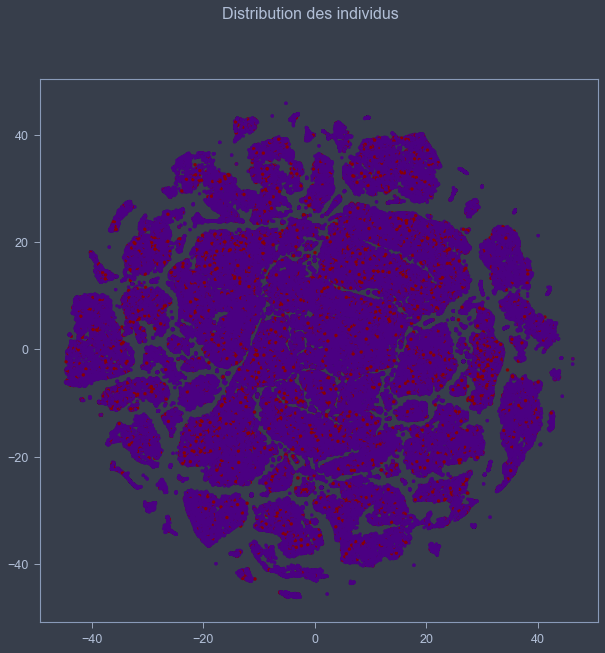

In [60]:
make_tsne(X.fillna(0),get_color(y))

### SMOTE

In [61]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X.fillna(0), y)
counter = Counter(y1)
print(counter)

Counter({0.0: 212103, 1.0: 212103})


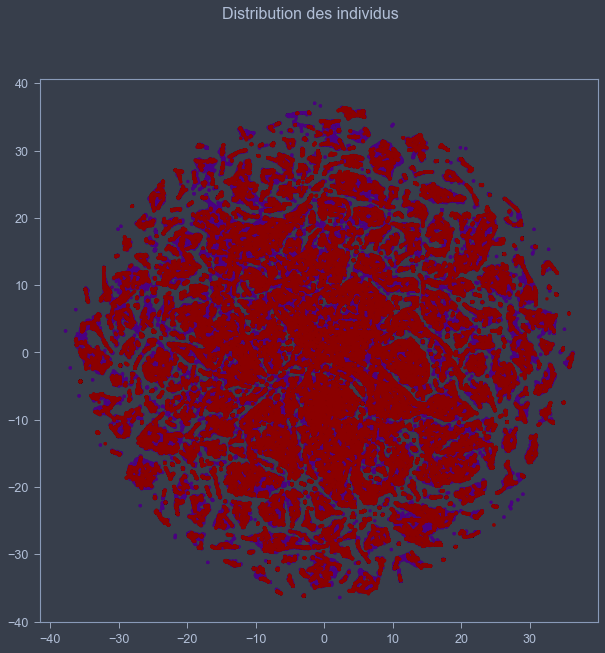

In [65]:
make_tsne(X1,get_color(y1))

Best Threshold=0.081078
F-score optimized Threshold=0.176, F-Score=0.30461


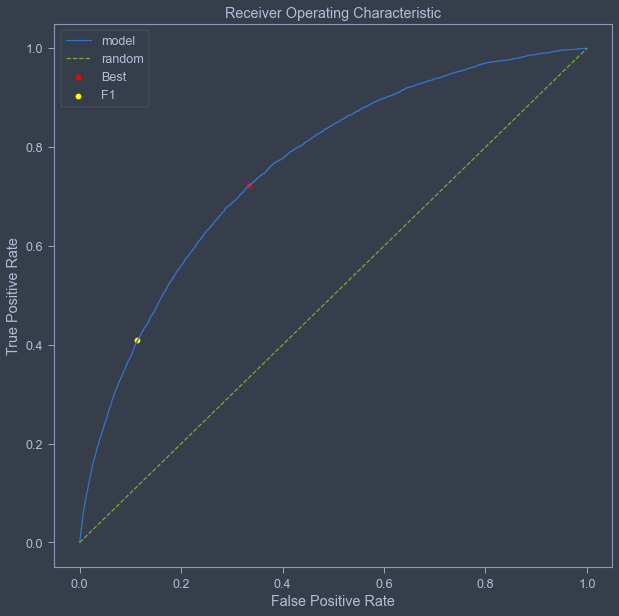

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.964224,0.162036,0.671284,0.563130,0.898539
recall,0.666704,0.722637,0.671284,0.694671,0.671284
f1-score,0.788327,0.264715,0.671284,0.526521,0.745452
support,70583.000000,6295.000000,0.671284,76878.000000,76878.000000


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.943863,0.242650,0.847069,0.593256,0.886445
recall,0.886134,0.409055,0.847069,0.647594,0.847069
f1-score,0.914088,0.304608,0.847069,0.609348,0.864182
support,70583.000000,6295.000000,0.847069,76878.000000,76878.000000


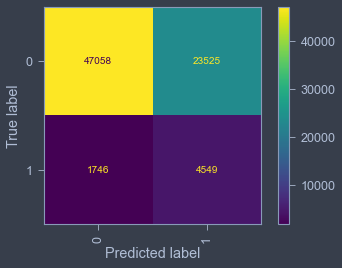

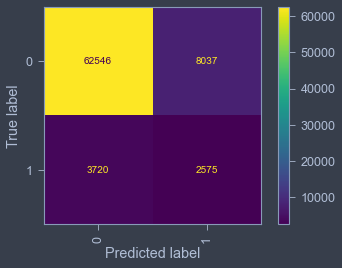

In [63]:
my_model.fit(X1, y1, eval_metric= 'auc', verbose= 2)
y_pred = my_model.predict(X_test)
y_proba = my_model.predict_proba(X_test)[:,1]
thres,ix = get_best_threshold(y_test,y_proba)
f_thres, ix_f1 = get_best_fscore_threshold(y_test,y_proba)
display_roc_curve(y_test,y_proba,ix,ix_f1)
display_confusion_matrix(y_test,to_labels(y_proba,thres))
display(display_classification_report(y_test,to_labels(y_proba,thres)))
display_confusion_matrix(y_test,to_labels(y_proba,f_thres))
display(display_classification_report(y_test,to_labels(y_proba,f_thres)))

In [64]:
roc_auc_score(y_test, y_proba)

0.7598468004989692

### SMOTE-Borderline

In [69]:
from imblearn.over_sampling import BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state = 101, kind = 'borderline-1')
X2, y2 = bsmote.fit_resample(X.fillna(0), y)
counter = Counter(y2)
print(counter)

Counter({0.0: 212103, 1.0: 212103})


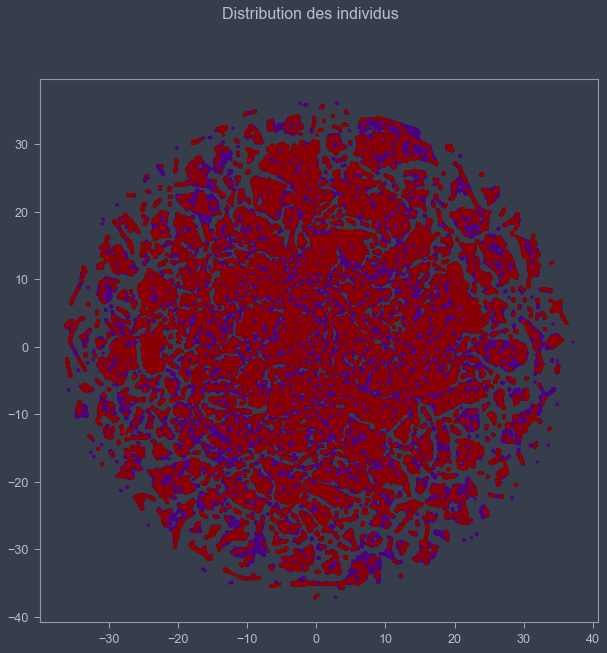

In [72]:
make_tsne(X2,get_color(y2))

Best Threshold=0.081323
F-score optimized Threshold=0.166, F-Score=0.30527


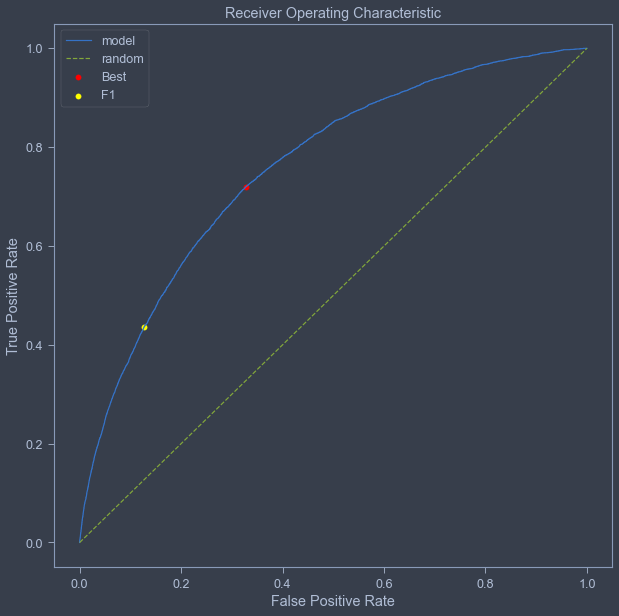

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.964180,0.163977,0.676565,0.564078,0.898657
recall,0.672712,0.719778,0.676565,0.696245,0.676565
f1-score,0.792496,0.267103,0.676565,0.529799,0.749475
support,70583.000000,6295.000000,0.676565,76878.000000,76878.000000


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.945503,0.235017,0.837717,0.590260,0.887327
recall,0.873596,0.435425,0.837717,0.654510,0.837717
f1-score,0.908128,0.305268,0.837717,0.606698,0.858764
support,70583.000000,6295.000000,0.837717,76878.000000,76878.000000


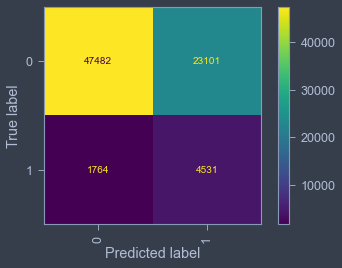

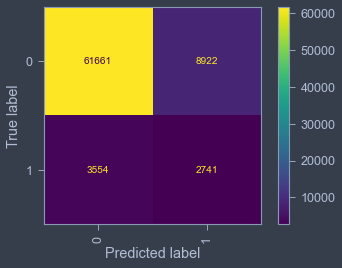

In [74]:
my_model.fit(X2, y2, eval_metric= 'auc', verbose= 2)
y_pred = my_model.predict(X_test)
y_proba = my_model.predict_proba(X_test)[:,1]
thres,ix = get_best_threshold(y_test,y_proba)
f_thres, ix_f1 = get_best_fscore_threshold(y_test,y_proba)
display_roc_curve(y_test,y_proba,ix,ix_f1)
display_confusion_matrix(y_test,to_labels(y_proba,thres))
display(display_classification_report(y_test,to_labels(y_proba,thres)))
display_confusion_matrix(y_test,to_labels(y_proba,f_thres))
display(display_classification_report(y_test,to_labels(y_proba,f_thres)))

In [71]:
roc_auc_score(y_test, y_proba)

0.7598468004989692

### SMOTE SVM

In [73]:
from imblearn.over_sampling import SVMSMOTE
svmsmote = SVMSMOTE(random_state = 101)
X3, y3 = svmsmote.fit_resample(X.fillna(0), y)
counter = Counter(y3)
print(counter)

Counter({0.0: 212103, 1.0: 212103})


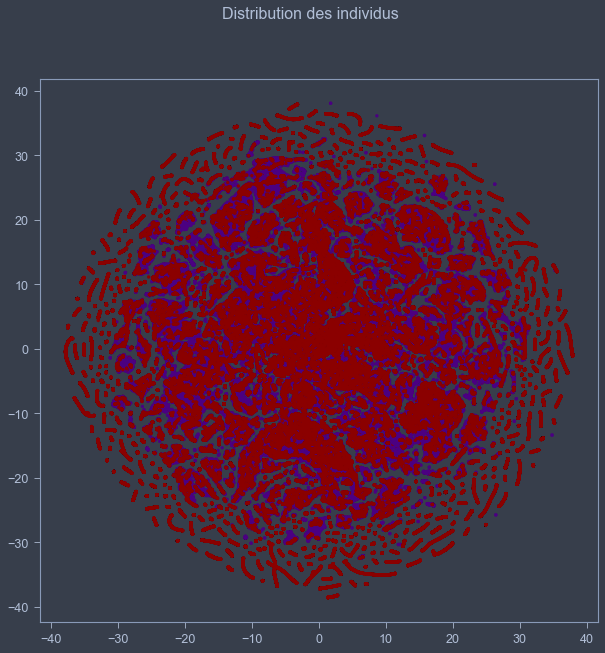

In [77]:
make_tsne(X3,get_color(y3))

Best Threshold=0.090813
F-score optimized Threshold=0.178, F-Score=0.30934


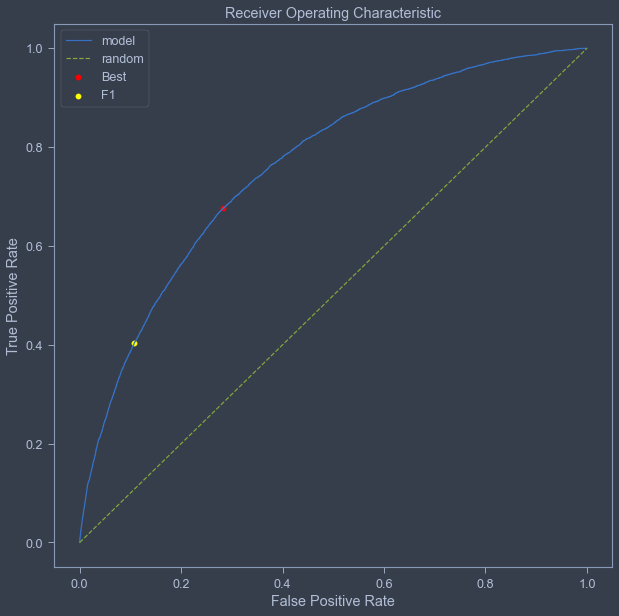

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.961340,0.175750,0.71365,0.568545,0.897014
recall,0.716943,0.676728,0.71365,0.696835,0.713650
f1-score,0.821347,0.279033,0.71365,0.550190,0.776941
support,70583.000000,6295.000000,0.71365,76878.000000,76878.000000


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.943746,0.250815,0.852468,0.597280,0.887007
recall,0.892510,0.403495,0.852468,0.648002,0.852468
f1-score,0.917413,0.309341,0.852468,0.613377,0.867622
support,70583.000000,6295.000000,0.852468,76878.000000,76878.000000


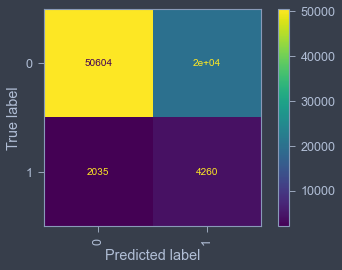

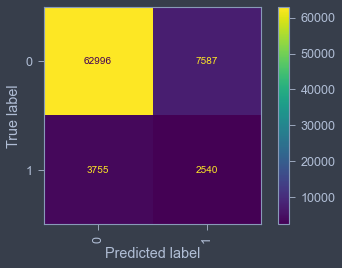

In [75]:
my_model.fit(X3, y3, eval_metric= 'auc', verbose= 2)
y_pred = my_model.predict(X_test)
y_proba = my_model.predict_proba(X_test)[:,1]
thres,ix = get_best_threshold(y_test,y_proba)
f_thres, ix_f1 = get_best_fscore_threshold(y_test,y_proba)
display_roc_curve(y_test,y_proba,ix,ix_f1)
display_confusion_matrix(y_test,to_labels(y_proba,thres))
display(display_classification_report(y_test,to_labels(y_proba,thres)))
display_confusion_matrix(y_test,to_labels(y_proba,f_thres))
display(display_classification_report(y_test,to_labels(y_proba,f_thres)))

In [76]:
roc_auc_score(y_test, y_proba)

0.7622315683144435

### ADASYN 

In [79]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state = 101)
X4, y4 = adasyn.fit_resample(X.fillna(0), y)
counter = Counter(y4)
print(counter)

Counter({1.0: 214428, 0.0: 212103})


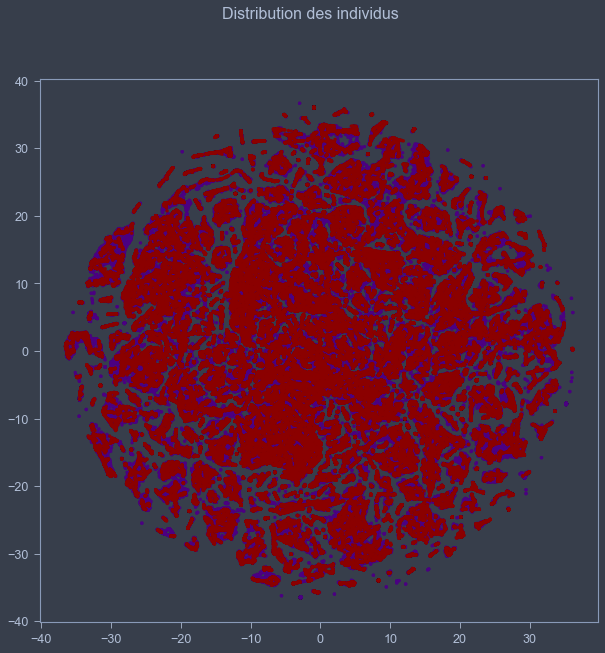

In [82]:
make_tsne(X4,get_color(y4))

Best Threshold=0.080836
F-score optimized Threshold=0.163, F-Score=0.30501


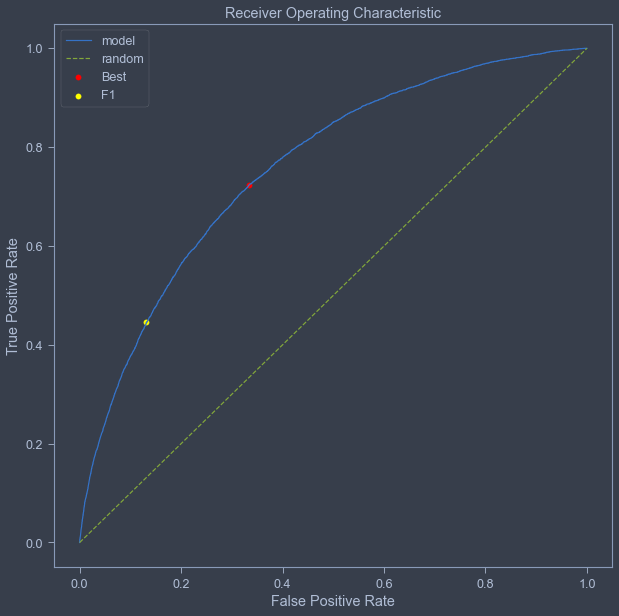

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.964381,0.161886,0.670348,0.563133,0.898670
recall,0.665529,0.724384,0.670348,0.694956,0.670348
f1-score,0.787557,0.264632,0.670348,0.526094,0.744738
support,70583.000000,6295.000000,0.670348,76878.000000,76878.000000


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.946116,0.231908,0.833789,0.589012,0.887634
recall,0.868424,0.445433,0.833789,0.656929,0.833789
f1-score,0.905607,0.305015,0.833789,0.605311,0.856429
support,70583.000000,6295.000000,0.833789,76878.000000,76878.000000


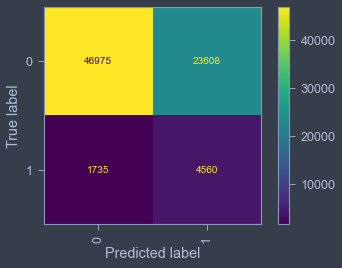

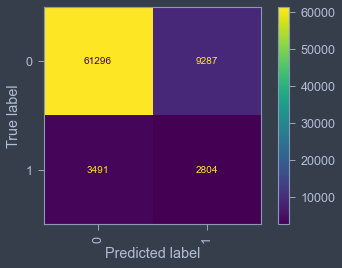

In [81]:
my_model.fit(X4, y4, eval_metric= 'auc', verbose= 2)
y_pred = my_model.predict(X_test)
y_proba = my_model.predict_proba(X_test)[:,1]
thres,ix = get_best_threshold(y_test,y_proba)
f_thres, ix_f1 = get_best_fscore_threshold(y_test,y_proba)
display_roc_curve(y_test,y_proba,ix,ix_f1)
display_confusion_matrix(y_test,to_labels(y_proba,thres))
display(display_classification_report(y_test,to_labels(y_proba,thres)))
display_confusion_matrix(y_test,to_labels(y_proba,f_thres))
display(display_classification_report(y_test,to_labels(y_proba,f_thres)))

In [80]:
roc_auc_score(y_test, y_proba)

0.7622315683144435